# Import Libararies

In [1]:
import os
import time
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.models import VGG16_Weights, MobileNet_V3_Large_Weights, DenseNet121_Weights

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define dataset path
dataset_path = "/kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset"

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Split Data

In [5]:
# Load the dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Define train/val/test split ratios
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size 

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Dataset Loader

In [6]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Number of classes
num_classes = len(full_dataset.classes)
print(f"Classes: {full_dataset.classes}, Total Classes: {num_classes}")

# Function to count images per class
def count_images_per_class(dataset):
    class_counts = {cls: 0 for cls in dataset.dataset.classes}
    for _, label in dataset.dataset.samples:
        class_counts[dataset.dataset.classes[label]] += 1
    return class_counts

# Get the count of images per class
class_counts = count_images_per_class(train_dataset)

# Print the count of images per class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

Classes: ['Central Serous Chorioretinopathy', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa'], Total Classes: 10
Class 'Central Serous Chorioretinopathy': 606 images
Class 'Diabetic Retinopathy': 3444 images
Class 'Disc Edema': 762 images
Class 'Glaucoma': 2880 images
Class 'Healthy': 2676 images
Class 'Macular Scar': 1937 images
Class 'Myopia': 2251 images
Class 'Pterygium': 102 images
Class 'Retinal Detachment': 750 images
Class 'Retinitis Pigmentosa': 834 images


# Class Distribution

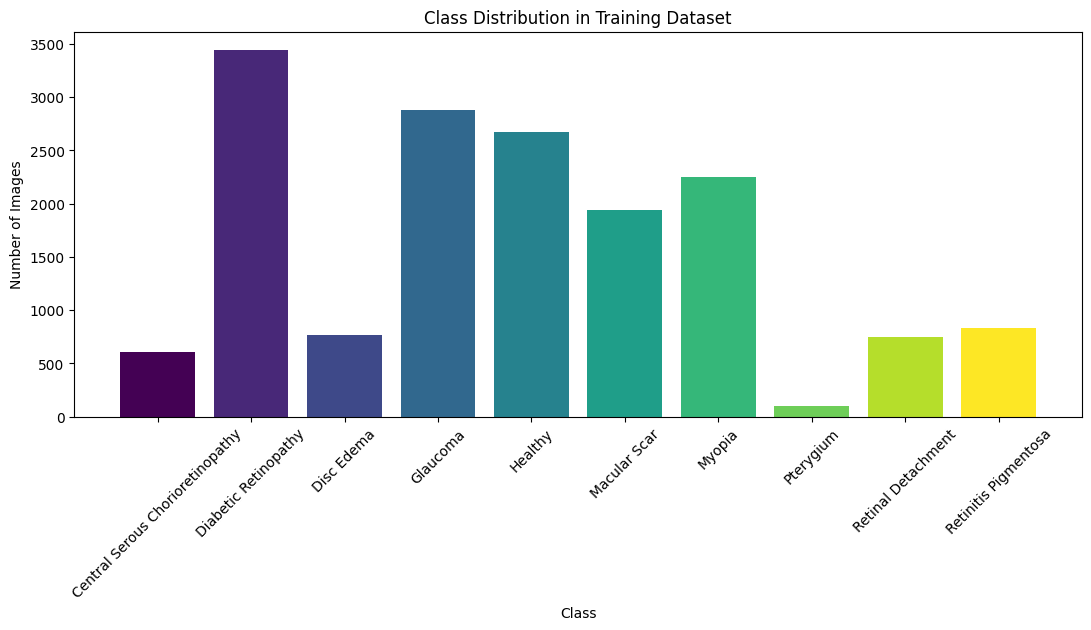

In [8]:
train_class_counts = count_images_per_class(train_dataset)

# Generate a list of colors based on the number of classes
colors = plt.cm.viridis(np.linspace(0, 1, len(train_class_counts)))

# Plot class distribution with different colors
plt.figure(figsize=(13, 5))
plt.bar(train_class_counts.keys(), train_class_counts.values(), color=colors)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.xticks(rotation=45)
plt.show()

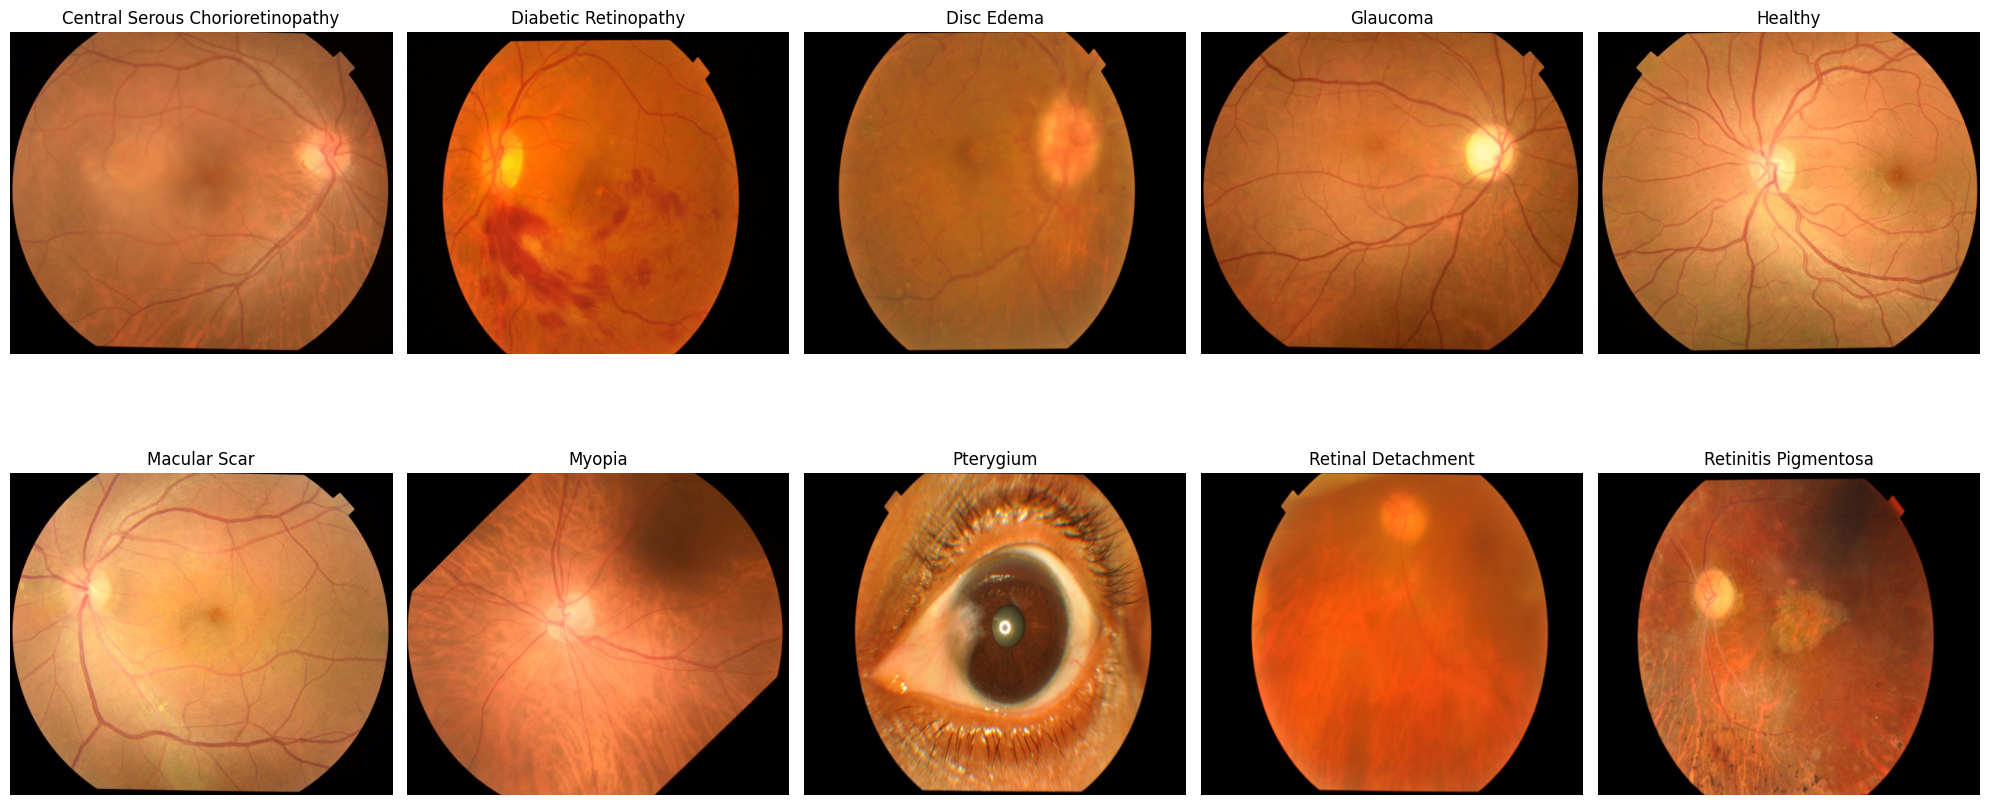

In [9]:
def show_random_images(dataset, num_images=1):
    rows = len(dataset.dataset.classes) // 5 + (len(dataset.dataset.classes) % 5 > 0)
    fig, axes = plt.subplots(rows, 5, figsize=(20, 5 * rows))

    axes = axes.flatten()

    for idx, cls in enumerate(dataset.dataset.classes):
        class_indices = [i for i, (_, label) in enumerate(dataset.dataset.samples) if dataset.dataset.classes[label] == cls]
        
        random_idx = random.choice(class_indices)
        img_path, _ = dataset.dataset.samples[random_idx]

        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis("off")
        axes[idx].set_title(cls)

    for i in range(len(dataset.dataset.classes), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

show_random_images(train_dataset)

# Mobilenet Pipeline

In [10]:
def get_model_mobilenetv3(num_classes, freeze_layers=True):
    model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
    
    if freeze_layers:
        total_blocks = len(model.features)
        for idx, module in enumerate(model.features):
            if idx < total_blocks - 2:
                for param in module.parameters():
                    param.requires_grad = False
            else:
                for param in module.parameters():
                    param.requires_grad = True
                    
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[0].in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

# DenseNet Pipeline

In [11]:
def get_model_densenet121(num_classes, freeze_layers=True):
    model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
    
    if freeze_layers:
        features = list(model.features.children())
        total_blocks = len(features)
        for idx, module in enumerate(features):
            if idx < total_blocks - 2:
                for param in module.parameters():
                    param.requires_grad = False
            else:
                for param in module.parameters():
                    param.requires_grad = True
        
    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.classifier.in_features, num_classes)
    )
    return model.to(device)

In [12]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0

    def should_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

In [13]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, early_stopping, epochs=20):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    all_val_labels, all_val_preds = [], []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            preds = outputs.argmax(1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
        
        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                preds = outputs.argmax(1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
                
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())
        
        val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step(val_loss)
        epoch_time = time.time() - start_time
        
        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s")
        
        if early_stopping.should_stop(val_loss):
            print("Early stopping triggered.")
            break
        
        if val_loss < early_stopping.best_loss:
            best_model_wts = copy.deepcopy(model.state_dict())
    
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs, all_val_labels, all_val_preds

In [14]:

def plot_accuracy_and_loss(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))
    # Accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.grid(True)
    
    # Loss curve
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [15]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def plot_per_class_accuracy(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    per_class_accuracy = np.diag(cm) / cm.sum(axis=1)
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, per_class_accuracy, color="skyblue")
    plt.xlabel("Classes")
    plt.ylabel("Accuracy")
    plt.title("Per-Class Accuracy")
    plt.xticks(rotation=45)
    plt.show()

In [16]:
class_names = full_dataset.classes
print("Classes:", class_names)
num_classes = len(class_names)  
epochs = 10
learning_rate = 0.001

Classes: ['Central Serous Chorioretinopathy', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']


In [17]:
print("\nTraining MobileNetV3 (unfreeze last 2 blocks) with Adam optimizer...\n")
mobilenet_model = get_model_mobilenetv3(num_classes, freeze_layers=True)
optimizer_mnv3 = optim.Adam(mobilenet_model.parameters(), lr=learning_rate)
scheduler_mnv3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mnv3, mode='min', factor=0.1, patience=3)
early_stopping_mnv3 = EarlyStopping(patience=5)

mobilenet_model, train_losses_mnv3, val_losses_mnv3, train_accs_mnv3, val_accs_mnv3, val_labels_mnv3, val_preds_mnv3 = train_model(
    mobilenet_model, nn.CrossEntropyLoss(), optimizer_mnv3, scheduler_mnv3,
    train_loader, val_loader, early_stopping_mnv3, epochs=epochs
)


Training MobileNetV3 (unfreeze last 2 blocks) with Adam optimizer...



Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 129MB/s] 


Epoch 1/10 - Train Acc: 0.6826, Train Loss: 0.8757, Val Acc: 0.7820, Val Loss: 0.5564, Time: 610.83s
Epoch 2/10 - Train Acc: 0.8207, Train Loss: 0.4724, Val Acc: 0.8199, Val Loss: 0.4746, Time: 477.12s
Epoch 3/10 - Train Acc: 0.8728, Train Loss: 0.3389, Val Acc: 0.8436, Val Loss: 0.4160, Time: 482.91s
Epoch 4/10 - Train Acc: 0.8940, Train Loss: 0.2818, Val Acc: 0.8544, Val Loss: 0.4851, Time: 474.74s
Epoch 5/10 - Train Acc: 0.9129, Train Loss: 0.2257, Val Acc: 0.8556, Val Loss: 0.4709, Time: 469.88s
Epoch 6/10 - Train Acc: 0.9171, Train Loss: 0.2077, Val Acc: 0.8541, Val Loss: 0.3892, Time: 468.87s
Epoch 7/10 - Train Acc: 0.9292, Train Loss: 0.1761, Val Acc: 0.8605, Val Loss: 0.4661, Time: 468.36s
Epoch 8/10 - Train Acc: 0.9296, Train Loss: 0.1619, Val Acc: 0.8565, Val Loss: 0.5211, Time: 471.15s
Epoch 9/10 - Train Acc: 0.9319, Train Loss: 0.1633, Val Acc: 0.8584, Val Loss: 0.3996, Time: 477.82s
Epoch 10/10 - Train Acc: 0.9356, Train Loss: 0.1500, Val Acc: 0.8575, Val Loss: 0.4517, Tim


MobileNetV3 Training Completed.



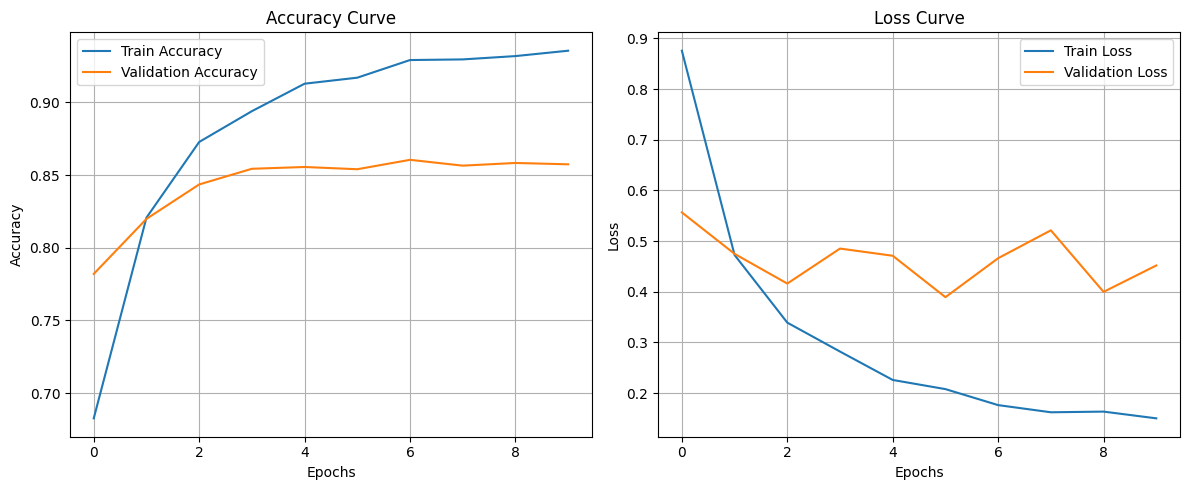

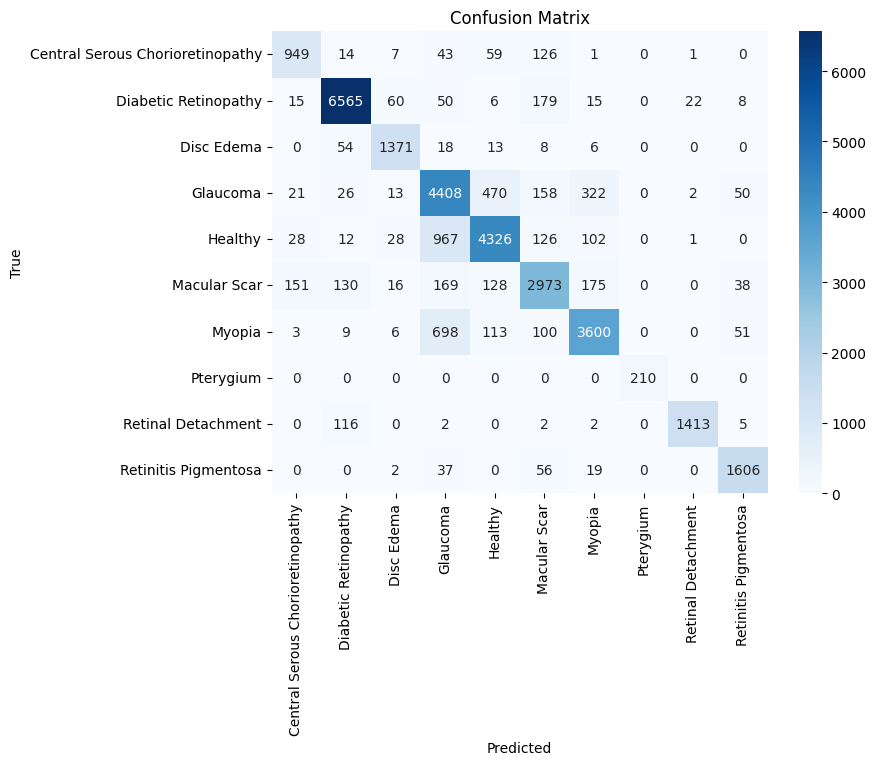

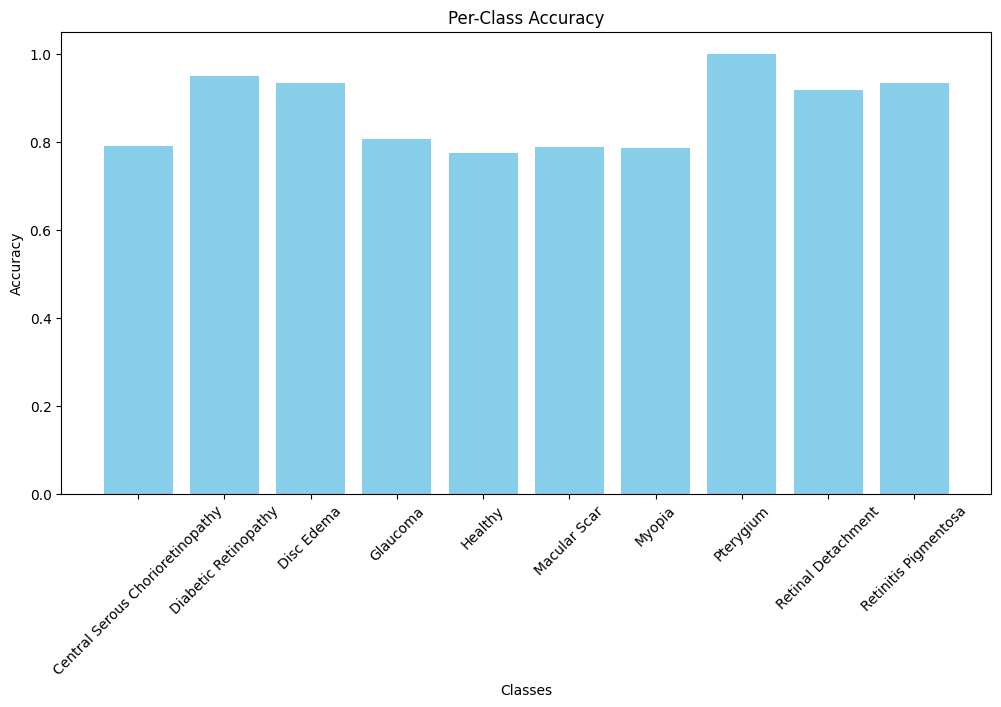

In [18]:
print("\nMobileNetV3 Training Completed.\n")
plot_accuracy_and_loss(train_losses_mnv3, val_losses_mnv3, train_accs_mnv3, val_accs_mnv3)
plot_confusion_matrix(val_labels_mnv3, val_preds_mnv3, class_names)
plot_per_class_accuracy(val_labels_mnv3, val_preds_mnv3, class_names)

# DenseNet

In [19]:
import torch
import numpy as np

def compute_classification_metrics(y_true, y_pred, num_classes, class_names):
    """
    Compute precision, recall, and F1-score for each class using PyTorch.

    Args:
        y_true (list or np.array): True labels from validation set
        y_pred (list or np.array): Predicted labels from validation set
        num_classes (int): Number of classes in dataset
        class_names (list): Class names for better readability
    
    Returns:
        None (Prints classification report)
    """
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)
    
    # Initialize TP, FP, FN
    true_positive = torch.zeros(num_classes)
    false_positive = torch.zeros(num_classes)
    false_negative = torch.zeros(num_classes)

    # Compute TP, FP, FN for each class
    for i in range(num_classes):
        true_positive[i] = ((y_pred == i) & (y_true == i)).sum().item()
        false_positive[i] = ((y_pred == i) & (y_true != i)).sum().item()
        false_negative[i] = ((y_pred != i) & (y_true == i)).sum().item()

    # Compute precision, recall, and F1-score
    precision = true_positive / (true_positive + false_positive + 1e-8)  # Avoid division by zero
    recall = true_positive / (true_positive + false_negative + 1e-8)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Print results
    print("\nClassification Report MobileNetV3:\n")
    print(f"{'Class':<15}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}")
    print("=" * 50)
    for i in range(num_classes):
        print(f"{class_names[i]:<15}{precision[i].item():<12.4f}{recall[i].item():<12.4f}{f1_score[i].item():<12.4f}")

    # Compute overall accuracy
    accuracy = (y_pred == y_true).sum().item() / len(y_true)
    print(f"\nOverall Accuracy: {accuracy:.4f}\n")

# Example Usage:
compute_classification_metrics(val_labels_mnv3, val_preds_mnv3, num_classes, class_names)



Classification Report MobileNetV3:

Class          Precision   Recall      F1-Score    
Central Serous Chorioretinopathy0.8132      0.7908      0.8019      
Diabetic Retinopathy0.9479      0.9487      0.9483      
Disc Edema     0.9122      0.9327      0.9223      
Glaucoma       0.6896      0.8059      0.7432      
Healthy        0.8457      0.7739      0.8082      
Macular Scar   0.7975      0.7865      0.7920      
Myopia         0.8487      0.7860      0.8161      
Pterygium      1.0000      1.0000      1.0000      
Retinal Detachment0.9819      0.9175      0.9486      
Retinitis Pigmentosa0.9135      0.9337      0.9235      

Overall Accuracy: 0.8442



In [20]:
# ----- DenseNet121 -----
print("\nTraining DenseNet121 (unfreeze last 2 blocks) with Adam optimizer...\n")
densenet_model = get_model_densenet121(num_classes, freeze_layers=True)
optimizer_dn = optim.Adam(densenet_model.parameters(), lr=learning_rate)
scheduler_dn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_dn, mode='min', factor=0.1, patience=3)
early_stopping_dn = EarlyStopping(patience=5)

densenet_model, train_losses_dn, val_losses_dn, train_accs_dn, val_accs_dn, val_labels_dn, val_preds_dn = train_model(
    densenet_model, nn.CrossEntropyLoss(), optimizer_dn, scheduler_dn,
    train_loader, val_loader, early_stopping_dn, epochs=epochs
)


Training DenseNet121 (unfreeze last 2 blocks) with Adam optimizer...



Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 153MB/s] 


Epoch 1/10 - Train Acc: 0.7200, Train Loss: 0.7763, Val Acc: 0.7980, Val Loss: 0.5582, Time: 518.87s
Epoch 2/10 - Train Acc: 0.8114, Train Loss: 0.5021, Val Acc: 0.8344, Val Loss: 0.4267, Time: 516.16s
Epoch 3/10 - Train Acc: 0.8574, Train Loss: 0.3826, Val Acc: 0.8501, Val Loss: 0.4031, Time: 525.07s
Epoch 4/10 - Train Acc: 0.8868, Train Loss: 0.3113, Val Acc: 0.8476, Val Loss: 0.4322, Time: 519.70s
Epoch 5/10 - Train Acc: 0.9010, Train Loss: 0.2723, Val Acc: 0.8608, Val Loss: 0.3910, Time: 516.69s
Epoch 6/10 - Train Acc: 0.9142, Train Loss: 0.2296, Val Acc: 0.8633, Val Loss: 0.3925, Time: 520.97s
Epoch 7/10 - Train Acc: 0.9185, Train Loss: 0.2181, Val Acc: 0.8648, Val Loss: 0.3935, Time: 523.93s
Epoch 8/10 - Train Acc: 0.9228, Train Loss: 0.2054, Val Acc: 0.8571, Val Loss: 0.4159, Time: 521.19s
Epoch 9/10 - Train Acc: 0.9272, Train Loss: 0.1869, Val Acc: 0.8648, Val Loss: 0.3937, Time: 527.79s
Epoch 10/10 - Train Acc: 0.9451, Train Loss: 0.1242, Val Acc: 0.8710, Val Loss: 0.3612, Tim


DenseNet121 Training Completed.



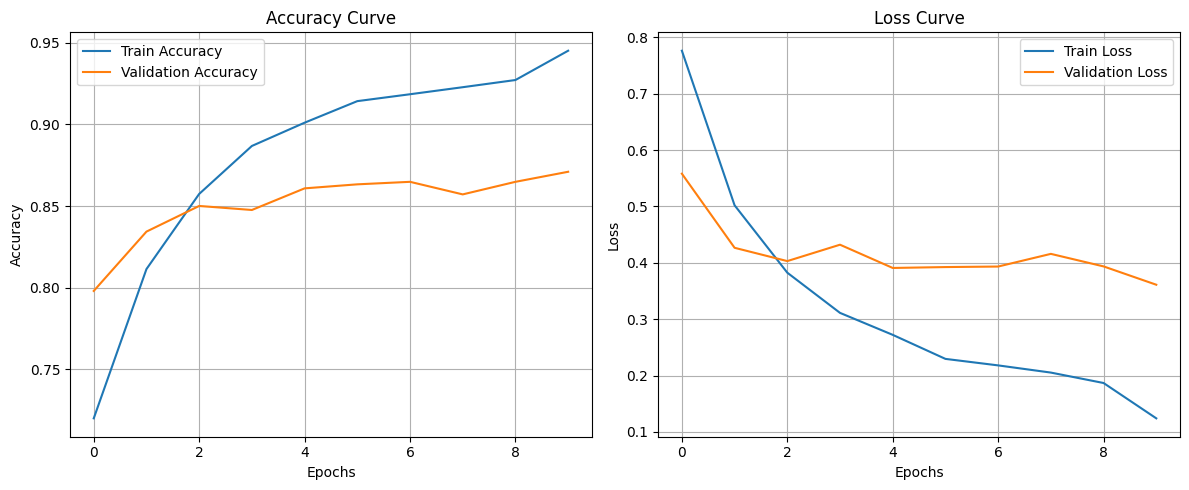

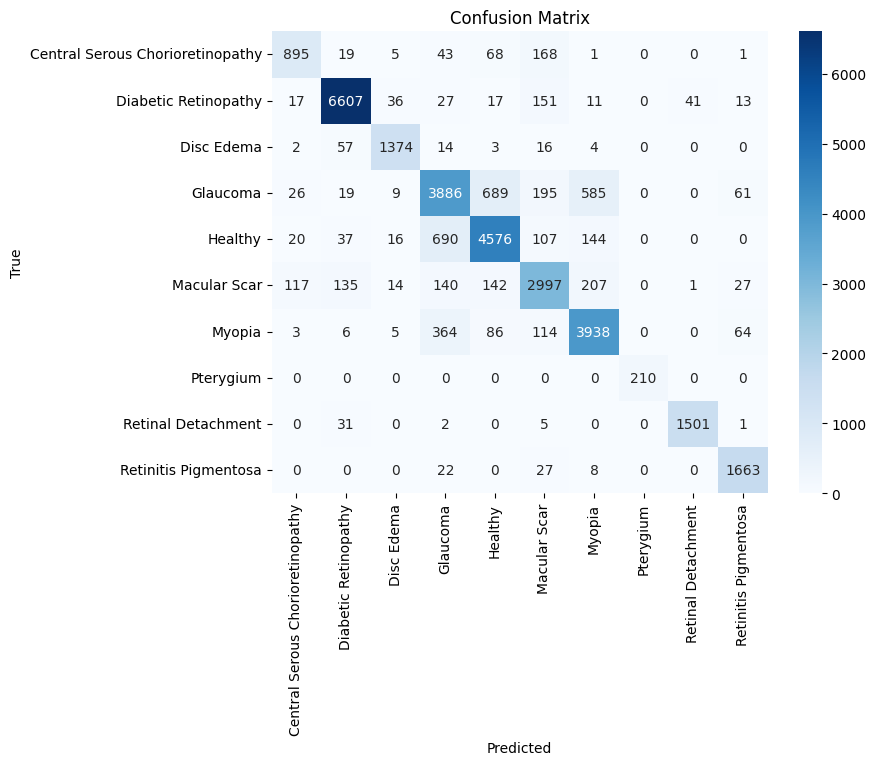

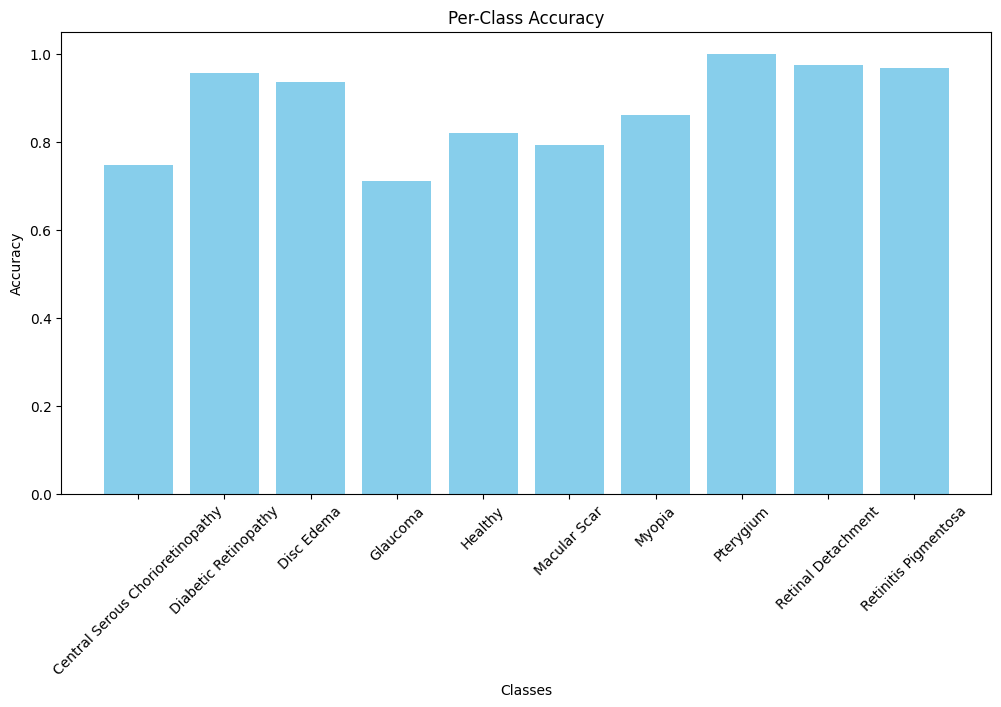

In [21]:
print("\nDenseNet121 Training Completed.\n")
plot_accuracy_and_loss(train_losses_dn, val_losses_dn, train_accs_dn, val_accs_dn)
plot_confusion_matrix(val_labels_dn, val_preds_dn, class_names)
plot_per_class_accuracy(val_labels_dn, val_preds_dn, class_names)

In [22]:
compute_classification_metrics(val_labels_dn, val_preds_dn, num_classes, class_names)


Classification Report MobileNetV3:

Class          Precision   Recall      F1-Score    
Central Serous Chorioretinopathy0.8287      0.7458      0.7851      
Diabetic Retinopathy0.9560      0.9548      0.9554      
Disc Edema     0.9417      0.9347      0.9382      
Glaucoma       0.7490      0.7104      0.7292      
Healthy        0.8199      0.8186      0.8193      
Macular Scar   0.7929      0.7929      0.7929      
Myopia         0.8040      0.8598      0.8310      
Pterygium      1.0000      1.0000      1.0000      
Retinal Detachment0.9728      0.9747      0.9737      
Retinitis Pigmentosa0.9087      0.9669      0.9369      

Overall Accuracy: 0.8512



# Save Model

In [23]:
# ---- Save DenseNet121 Model ----
densenet_path = "best_densenet121_model.pth"
torch.save(densenet_model.state_dict(), densenet_path)
print(f"DenseNet121 model saved to: {densenet_path}")

# ---- Save MobileNetV3 Model ----
mobilenet_path = "best_mobilenetv3_model.pth"
torch.save(mobilenet_model.state_dict(), mobilenet_path)
print(f"MobileNetV3 model saved to: {mobilenet_path}")

DenseNet121 model saved to: best_densenet121_model.pth
MobileNetV3 model saved to: best_mobilenetv3_model.pth
